# Introduction

Happiness is a concept that is hard to explain and, until recently, many would say it was even harder to measure. But researchers have come up with tools for measuring happiness with various approaches such as biological, behavioral, implicit measures, other reports (asking others), self reports \cite{happiness1}.

Questionnaires and surveys have been made available by the scientific community to measure happiness on a scale that can be understood and utilized in future studies and decision makings. [Subjective Happiness Scale](http://sonjalyubomirsky.com/subjective-happiness-scale-shs/) and [Oxford Happiness Inventory](http://www.meaningandhappiness.com/oxford-happiness-questionnaire/214/) are a couple of examples. 

In this notebook we have used data from [World Happiness Report](https://worldhappiness.report/ "WHR") for assessment, modeling and prediction using machine learning techniques. WHR uses the [Gallup World Poll](https://www.gallup.com/analytics/232838/world-poll.aspx) for data collection. The World Happiness Report 2020 is their eighth and latest report. It delves into the attributes that contribute to the level of a person's (country's) happiness. 

The WHR20 has data from years 2005-2019 from 156 countries. 

## Problem Statement
Given the multiple attributes about a country train a model to predict the happiness score. To accomplish this we will try unsupervised and supervised machine learning algorithms on the data and study the results and comparisons to conclude which model works best with our data for predicting happiness. 

## Approach 
1. Explore the dataset
2. Visualize the data 
3. Perform Feature Selection
4. Perform Cluster Analysis
5. Perform Regression Analysis
6. Compare the results of various models of regression
7. Draw conclusions

### Library Imports

In [1]:
import numpy as np
import pandas as pd 
import os
from time import time

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt                  
import chart_studio.plotly as py  
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec
import plotly.figure_factory as ff

from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
from impyute.imputation.cs import mice
from sklearn import preprocessing
import statsmodels.api as sm
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVR 
from sklearn.metrics import classification_report,mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,RidgeCV, LassoCV, Ridge, Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

start= time()

In [2]:
performance_metrics=[['Misclassified Samples','Accuracy','Mean Squared Error','Coeffiecent of Determination']]
def analysis_score(model,ip,op,pred):
    print('Misclassified samples: {0}'.format((op != pred).sum()))
    print('Misclassified samples on basis of difference greater than standard deviation: {0}'.format((abs(op-pred)>np.std(pred)).sum()))
    print('Test data accuracy: {0:.2f}'.format(model.score(ip, op)))
    print('Mean squared error: %.2f'% mean_squared_error(op, pred))
    print('Coefficient of determination: %.2f'% r2_score(op, pred))
    performance_metrics.append([(op != pred).sum(),round(model.score(ip, op),2),round(mean_squared_error(op, pred),2),round(r2_score(op, pred),2)])

# Dataset

The data come in form of an Excel file. A single record in the original dataset consists of identification labels (Country and Year), a continuous value of happiness score (treated further as a response variable) and a series of numerical values corresponding to economical and social attributes. To enrich the data visualisation part of the report and look for potential patterns in the data we created an additional column by assigning a 'Region' label to each observation, based on geographical location of the country.

Below we take a closer look at how the variables are definied and how they were calculated:
- Happiness score - originally named 'Life Ladder' - is a response to the question asked in street polls during several releases of the Gallup World Poll (GWP), averaged on the country level. Respondents were asked to place themselves on a ladder step from 0 to 10, where 0 meant they were at that moment living the worst possible life they could imagine for themselves and 10 meant the best possible life they could imagine.
- GDP per capita - gross domestic product in purchasing power parity (PPP).
- Social support - measure of people's binary reponses whether or not they have someone among family or friends they can count on when they need help.
- Healthy Life Expectancy - estimates of the World Health Organisation.
- Freedom to make life choices - average score obtained from the GWP question about the level of freedom when choosing what to do with one's life.
- Generosity - measure of how generously people donate to charities scaled by GDP per capita.
- Trust - measure of people's beliefs regarding the spread of corruption in the government and business circles.
- Positive affect - measure of how often people laugh and experience the feeling of happiness and enjoyment.
- Negative effect - measure of how often people worry and experience the feeling of sadness and anger.
- Democratic quality - measure of a degree to which citizens participate in the process of selecting goverment, as well as reflection of freedom of expression, association and political stability.
- Delivery quality - measure of government effectiveness, corruption control and regulatory quality.
- Gini index of household income reported in GWP - economical variable based on the household income reported by respondents.
- Gini index from the World Bank - economical factor calculated from the data gathered by governmental agencies and World Bank country departments.

In [3]:
df = pd.read_excel('WHR20.xls')
df.groupby(['year','Region']).first()

Country name  Life Ladder  \
year Region                                                         
2005 Australia and New Zealand             Australia     7.340688   
     Central and Eastern Europe       Czech Republic     6.439257   
     Eastern Asia                              Japan     6.515817   
     Latin America and Caribbean              Brazil     6.636771   
     Middle East and Northern Africa           Egypt     5.167754   
...                                              ...          ...   
2019 North America                            Canada     7.109076   
     Southeastern Asia                      Cambodia     4.998285   
     Southern Asia                       Afghanistan     2.375092   
     Sub-Saharan Africa                        Benin     4.976361   
     Western Europe                          Austria     7.195361   

                                      Log GDP per capita  Social support  \
year Region                                                                
2005 Australia and New Zealand                 10.570512        0.967892   
     Central and Eastern Europe                10.157401        0.918759   
     Eastern Asia                              10.481733        0.927712   
     Latin America and Caribbean                9.421541        0.882923   
     Middle East and Northern Africa            9.004121        0.847842   
...                                                  ...             ...   
2019 North America                             10.694495        0.925304   
     Southeastern Asia                          8.314613        0.759175   
     Southern Asia                              7.458469        0.419973   
     Sub-Saharan Africa                         7.710536        0.442154   
     Western Europe                            10.756180        0.964489   

                                      Healthy life expectancy at birth  \
year Region                                                              
2005 Australia and New Zealand                               71.400002   
     Central and Eastern Europe                              67.000000   
     Eastern Asia                                            73.199997   
     Latin America and Caribbean                             63.299999   
     Middle East and Northern Africa                         59.700001   
...                                                                ...   
2019 North America                                           73.800003   
     Southeastern Asia                                       62.000000   
     Southern Asia                                           52.400002   
     Sub-Saharan Africa                                      54.700001   
     Western Europe                                          73.300003   

                                      Freedom to make life choices  \
year Region                                                          
2005 Australia and New Zealand                            0.934973   
     Central and Eastern Europe                           0.865235   
     Eastern Asia                                         0.867779   
     Latin America and Caribbean                          0.882186   
     Middle East and Northern Africa                      0.817362   
...                                                            ...   
2019 North America                                        0.911526   
     Southeastern Asia                                    0.956799   
     Southern Asia                                        0.393656   
     Sub-Saharan Africa                                   0.770360   
     Western Europe                                       0.903428   

                                      Generosity  Perceptions of corruption  \
year Region                                                                   
2005 Australia and New Zealand               NaN                   0.390416   
     Central and Eastern Europe           

## Data Cleaning

First we'll check how many missing values are we dealing with in each column. To do this we are using the pandas method isnull(). This method returns true for every missing, null or NaN value. 

In [4]:
df.isnull().sum()

Country name                                                                0
Region                                                                      0
year                                                                        0
Life Ladder                                                                 0
Log GDP per capita                                                         29
Social support                                                             13
Healthy life expectancy at birth                                           52
Freedom to make life choices                                               31
Generosity                                                                 83
Perceptions of corruption                                                 103
Positive affect                                                            21
Negative affect                                                            15
Confidence in national government                               

Dropping columns that are mostly empty and renaming other columns.

In [5]:
df = df.drop(columns=['GINI index (World Bank estimate)',
                      'gini of household income reported in Gallup, by wp5-year',
                      'Most people can be trusted, Gallup', 
                      'Most people can be trusted, WVS round 1981-1984',
                      'Most people can be trusted, WVS round 1989-1993',
                      'Most people can be trusted, WVS round 1994-1998',
                      'Most people can be trusted, WVS round 1999-2004',
                      'Most people can be trusted, WVS round 2005-2009',
                      'Most people can be trusted, WVS round 2010-2014'])

df.rename(columns = {'Country name' : 'Country',
                     'year' : 'Year',
                     'Life Ladder' : 'Happiness Score',
                     'Log GDP per capita' : 'Economy',
                     'Social support' : 'Social Support',
                     'Freedom to make life choices' : 'Freedom',
                     'Healthy life expectancy at birth' : 'Life Expectancy',
                     'Perceptions of corruption' : 'Trust',
                     'GINI index (World Bank estimate), average 2000-2017, unbalanced panel':'GINI'}, 
          inplace = True)

columns = ['Economy', 'Social Support', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust',
           'Positive affect', 'Negative affect', 'Confidence in national government', 
           'Democratic Quality','Delivery Quality', 'Standard deviation of ladder by country-year', 
           'Standard deviation/Mean of ladder by country-year','GINI']

The data which are missing from the original dataset are filled by 2 methods in first method wherever mean of the data can be taken it is taken and filled. Consequently the data which can't be filled by mean is calculated by using a special imputation algorithm called MICE (MultiVariate Imputation by Chained Equation) where in the algorithm takes all features as potentially connected forming chained equation and having the best fit for missing values so that the chained equation would have least error in Linear regression.

In [6]:
# Taking mean of the data to fill the missing values
for column in columns:
    df[column] = df.groupby('Country')[column].transform(lambda grp: grp.fillna(np.mean(grp))) 

#Using MICE algorithm to fill the missing data
finding=np.array(df.values[:,3:],dtype=float)

interpolated = mice(finding)

ctr=1
for column in columns:
    df[column]=df[column].replace(df.values[:,ctr+3],interpolated[:,ctr])
    ctr+=1

## Pre-Processing Data

First for ease of computation and visualization, the dataset is rounded to 3 decimal places. Then 3 different types of data transformation is applied, namely:
- MinMaxScaling: In this method the dataset is scaled in such a way that whole datet lies between 0 to 1
- Standardization: In this method the whole dataset is transformed in such a way that it is centered around mean of the data and divided by standard deviation
- Normalization: In this method the whole dataset is tranformed in such a way that sum of squares of each value in a column adds up to 1

In [7]:
df=df.round(3)

mms=MinMaxScaler()
df_mms=df.copy()
df_mms[columns] = mms.fit_transform(df_mms[columns])
df_mms=df_mms.round(3)
df_mms

,Country,Region,Year,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Generosity,Trust,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI
0,Afghanistan,Southern Asia,2008,3.724,0.131,0.231,0.413,0.633,0.505,0.893,0.315,0.281,0.587,0.129,0.113,0.284,0.386,0.332
1,Afghanistan,Southern Asia,2009,4.402,0.163,0.376,0.422,0.579,0.527,0.860,0.421,0.248,0.587,0.100,0.118,0.268,0.289,0.332
2,Afghanistan,Southern Asia,2010,4.758,0.183,0.357,0.431,0.470,0.458,0.709,0.476,0.309,0.249,0.113,0.122,0.317,0.294,0.332
3,Afghanistan,Southern Asia,2011,3.832,0.178,0.331,0.438,0.327,0.499,0.734,0.465,0.296,0.257,0.131,0.122,0.287,0.373,0.332
4,Afghanistan,Southern Asia,2012,3.783,0.194,0.331,0.445,0.376,0.572,0.782,0.624,0.297,0.396,0.150,0.171,0.291,0.384,0.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,Zimbabwe,Sub-Saharan Africa,2015,3.703,0.260,0.640,0.480,0.563,0.212,0.818,0.632,0.154,0.563,0.386,0.181,0.416,0.517,0.487
1844,Zimbabwe,Sub-Saharan Africa,2016,3.735,0.259,0.686,0.493,0.653,0.241,0.727,0.669,0.203,0.681,0.384,0.177,0.596,0.685,0.487
1845,Zimbabwe,Sub-Saharan Africa,2017,3.638,0.264,0.666,0.507,0.681,0.237,0.755,0.778,0.227,0.664,0.371,0.183,0.559,0.670,0.487
1846,Zimbabwe,Sub-Saharan Africa,2018,3.616,0.273,0.696,0.520,0.695,0.266,0.853,0.624,0.207,0.521,0.379,0.190,0.510,0.627,0.487


In [8]:
Sc=StandardScaler()
df_std=df.copy()
df_std[columns]=Sc.fit_transform(df_std[columns])
df_std=df_std.round(3)
df_std

,Country,Region,Year,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Generosity,Trust,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI
0,Afghanistan,Southern Asia,2008,3.724,-1.805,-3.033,-1.659,-0.149,1.106,0.739,-1.773,-0.110,0.519,-2.069,-1.705,-0.650,0.612,-0.134
1,Afghanistan,Southern Asia,2009,4.402,-1.659,-2.183,-1.605,-0.422,1.242,0.570,-1.161,-0.357,0.519,-2.200,-1.684,-0.771,-0.046,-0.134
2,Afghanistan,Southern Asia,2010,4.758,-1.567,-2.292,-1.551,-0.974,0.816,-0.188,-0.846,0.090,-1.020,-2.140,-1.665,-0.406,-0.015,-0.134
3,Afghanistan,Southern Asia,2011,3.832,-1.591,-2.444,-1.508,-1.702,1.069,-0.061,-0.911,-0.004,-0.980,-2.056,-1.664,-0.626,0.528,-0.134
4,Afghanistan,Southern Asia,2012,3.783,-1.517,-2.444,-1.465,-1.457,1.526,0.177,0.007,0.008,-0.351,-1.969,-1.446,-0.596,0.597,-0.134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,Zimbabwe,Sub-Saharan Africa,2015,3.703,-1.218,-0.634,-1.256,-0.505,-0.724,0.358,0.053,-1.040,0.411,-0.875,-1.401,0.344,1.507,0.626
1844,Zimbabwe,Sub-Saharan Africa,2016,3.735,-1.225,-0.364,-1.176,-0.044,-0.544,-0.098,0.266,-0.687,0.947,-0.884,-1.418,1.697,2.646,0.626
1845,Zimbabwe,Sub-Saharan Africa,2017,3.638,-1.199,-0.482,-1.095,0.096,-0.569,0.045,0.896,-0.510,0.868,-0.945,-1.392,1.418,2.547,0.626
1846,Zimbabwe,Sub-Saharan Africa,2018,3.616,-1.159,-0.305,-1.015,0.166,-0.390,0.538,0.007,-0.652,0.219,-0.908,-1.363,1.048,2.249,0.626


In [9]:
df_norm=df.copy()
df_norm[columns]=normalize(df_norm[columns],axis=0,norm='l1')
df_norm

,Country,Region,Year,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Generosity,Trust,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI
0,Afghanistan,Southern Asia,2008,3.724,0.000418,0.000301,0.000435,0.000526,0.000765,0.000643,0.000395,0.000522,0.000654,-0.001403,-0.001118,0.000468,0.000650,0.000527
1,Afghanistan,Southern Asia,2009,4.402,0.000428,0.000368,0.000439,0.000497,0.000859,0.000619,0.000446,0.000480,0.000654,-0.001486,-0.001104,0.000454,0.000533,0.000527
2,Afghanistan,Southern Asia,2010,4.758,0.000434,0.000360,0.000442,0.000439,0.000564,0.000515,0.000471,0.000557,0.000319,-0.001448,-0.001092,0.000495,0.000538,0.000527
3,Afghanistan,Southern Asia,2011,3.832,0.000433,0.000348,0.000445,0.000363,0.000739,0.000533,0.000466,0.000540,0.000328,-0.001395,-0.001091,0.000471,0.000635,0.000527
4,Afghanistan,Southern Asia,2012,3.783,0.000438,0.000348,0.000448,0.000389,0.001056,0.000566,0.000542,0.000542,0.000465,-0.001340,-0.000948,0.000474,0.000648,0.000527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,Zimbabwe,Sub-Saharan Africa,2015,3.703,0.000458,0.000491,0.000461,0.000488,-0.000500,0.000590,0.000545,0.000362,0.000630,-0.000648,-0.000919,0.000580,0.000810,0.000608
1844,Zimbabwe,Sub-Saharan Africa,2016,3.735,0.000458,0.000512,0.000466,0.000537,-0.000376,0.000528,0.000563,0.000423,0.000747,-0.000654,-0.000930,0.000732,0.001013,0.000608
1845,Zimbabwe,Sub-Saharan Africa,2017,3.638,0.000459,0.000503,0.000471,0.000551,-0.000393,0.000547,0.000615,0.000453,0.000730,-0.000693,-0.000912,0.000701,0.000995,0.000608
1846,Zimbabwe,Sub-Saharan Africa,2018,3.616,0.000462,0.000517,0.000476,0.000559,-0.000269,0.000615,0.000542,0.000429,0.000589,-0.000669,-0.000894,0.000659,0.000942,0.000608


## Visualizing the data

In [10]:
whr = df_mms.groupby('Year') 
data2019 = whr.get_group(2019)

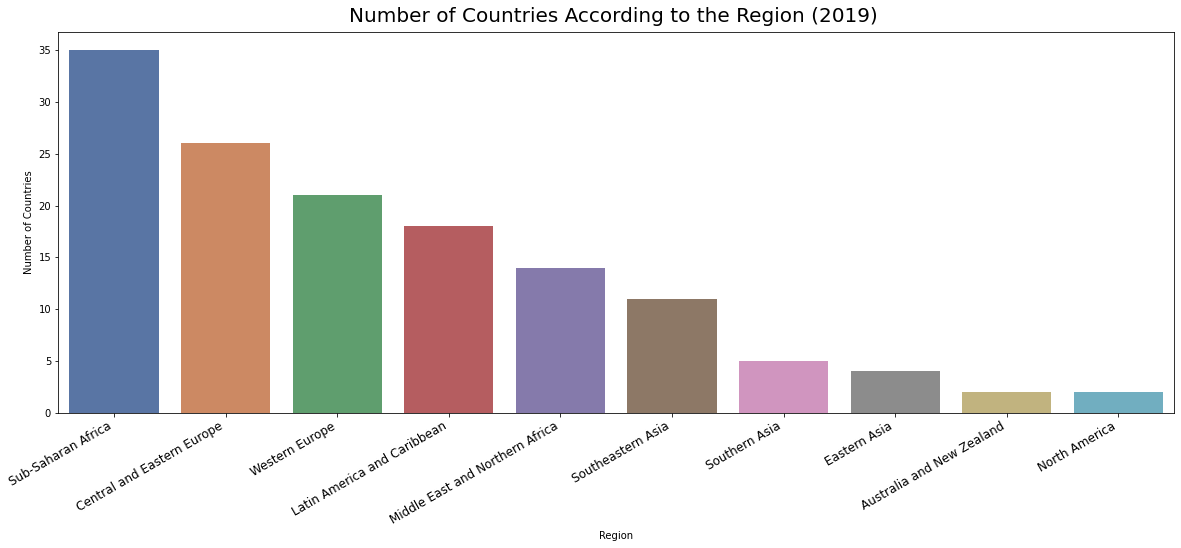

In [11]:
dt2019 = data2019.Region.value_counts()
plt.figure(figsize=(20,7))
sns.barplot(x = dt2019.index, y = dt2019.values, palette="deep")
plt.xlabel('Region')
plt.xticks(rotation = 30,fontweight=50,horizontalalignment='right',fontsize=12)
plt.ylabel('Number of Countries')
plt.title('Number of Countries According to the Region (2019) ', color = 'black', fontsize = 20, pad = 10)
plt.show()

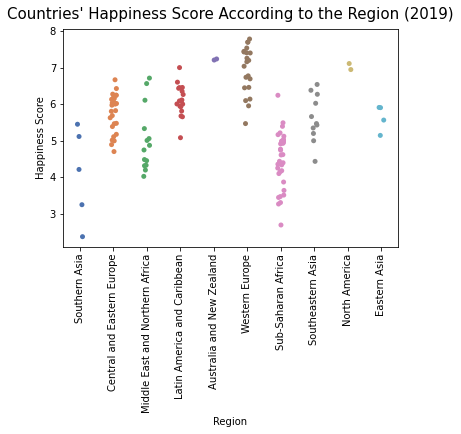

In [12]:
sns.stripplot(x = "Region", y = "Happiness Score", data = data2019, jitter = True, palette="deep")
plt.xticks(rotation = 90)
plt.title("Countries' Happiness Score According to the Region (2019)", color = 'black', fontsize = 15, pad=10)
plt.show()

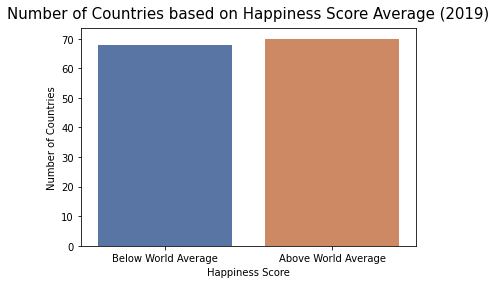

In [13]:
above_mean_HS =['Above World Average' if i >= data2019.mean()['Happiness Score'] else 'Below World Average' for i in data2019['Happiness Score']]
df1 = pd.DataFrame({'HappinessScore' : above_mean_HS})
sns.countplot(x = df1['HappinessScore'], palette="deep")
plt.xlabel('Happiness Score')
plt.ylabel('Number of Countries')
plt.title('Number of Countries based on Happiness Score Average (2019)',  fontsize = 15, pad = 10)
plt.show()

In [14]:
trace1 = go.Box(
    y = data2019.Economy,
    name = 'Economic Situations of Countries in 2019',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace2 = go.Box(
    y = data2019.Trust,
    name = 'Government Corruption Index in 2019',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
data = [trace1, trace2]
lout = go.Layout(title='Statisitcal Distribution of Economic Situation and Government Corruption of Countries in 2019')
iplot({'data':data,'layout':lout})

In [15]:
data2019.sort_values(by=['Happiness Score'], inplace=True, ascending=False)



df2019 = data2019.iloc[:3, :]


trace1 = go.Bar(
                x = df2019.Country,
                y = df2019.Economy,
                name = "Economy",
                marker = dict(color = 'rgba(125, 25, 200, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace2 = go.Bar(
                x = df2019.Country,
                y = df2019['Social Support'],
                name = "Social support",
                marker = dict(color = 'rgba(25, 25, 25, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace3 = go.Bar(
                x = df2019.Country,
                y = df2019['Life Expectancy'],
                name = "Life expectancy",
                marker = dict(color = 'rgba(190, 200, 100, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace4 = go.Bar(
                x = df2019.Country,
                y = df2019.Trust,
                name = "Trust",
                marker = dict(color = 'rgba(50, 150, 50, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace5 = go.Bar(
                x = df2019.Country,
                y = df2019.Generosity,
                name = "Generosity",
                marker = dict(color = 'rgba(255, 70, 12, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace6 = go.Bar(
                x = df2019.Country,
                y = df2019.Freedom,
                name = "Freedom",
                marker = dict(color = 'rgba(255, 25, 55, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
data = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(barmode = 'group', title = 'Top 3 Countries in 2017 According to the Different Parameters')
fig = go.Figure(data = data, layout = layout)
iplot(fig)
plt.show()

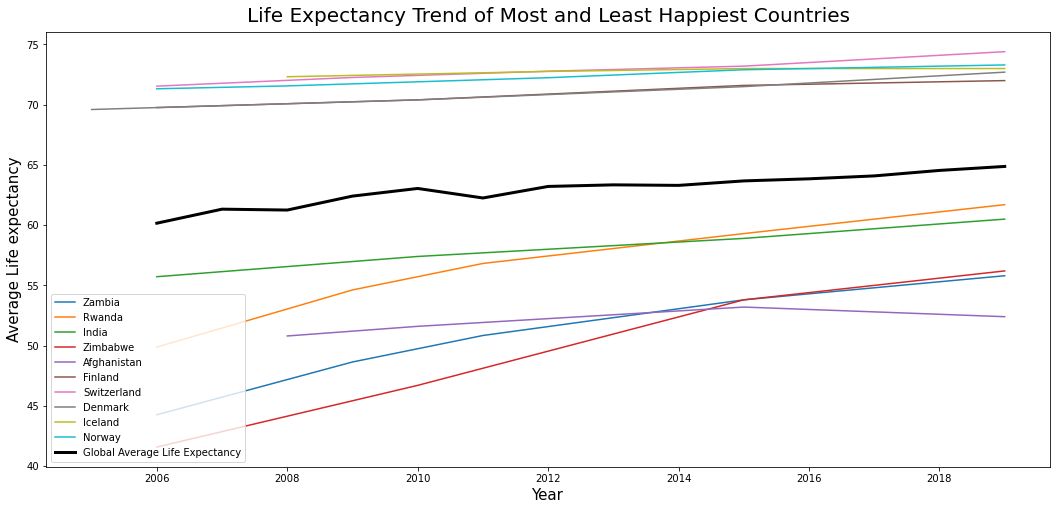

In [16]:
countries=data2019.values[-5:,0]
countries=np.append(countries,data2019.values[:5,0])
plt.figure(figsize=(18,8))
for country in countries:
    plt.plot(df['Year'].loc[df['Country']==country],df['Life Expectancy'].loc[df['Country']==country]
             , label=country,linewidth=1.5)
global_mean=df.groupby(['Year'])['Life Expectancy'].mean()
plt.plot(global_mean[1:][:],color='black',linewidth=3,label='Global Average Life Expectancy') 
plt.legend(loc=3)
plt.title('Life Expectancy Trend of Most and Least Happiest Countries',fontsize=20,pad=10)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Average Life expectancy',fontsize=15)
plt.show()

In [17]:
fig = px.scatter(data2019, x='Happiness Score', y='Economy', text='Country')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=1000, title = "Happiness Score vs Economy"
)
fig.show()

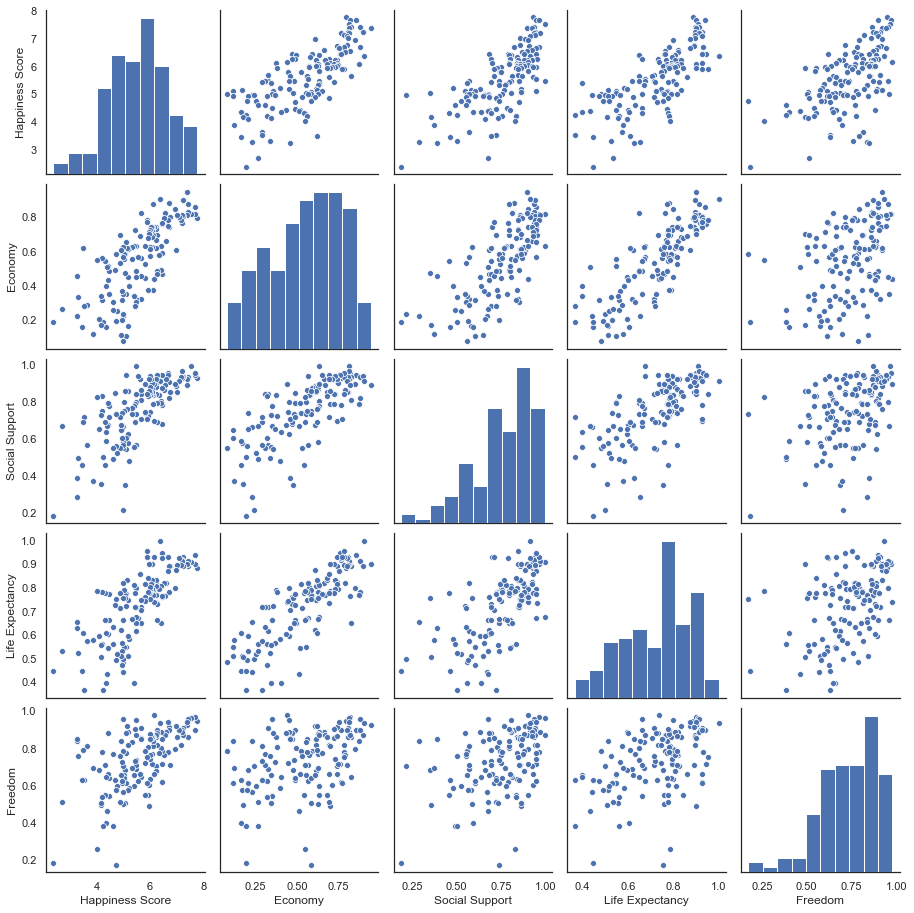

In [18]:
sns.set(style="white",font_scale=1)
var=sns.pairplot(data2019[['Happiness Score','Economy', 'Social Support', 'Life Expectancy', 'Freedom']])
plt.show()

The above graph reveals us trends features when plotted against each other

In [19]:
data = dict(type = 'choropleth', 
           locations = data2019['Country'],
           locationmode = 'country names',
           z = data2019['Happiness Score'], 
           text = data2019['Country'],
           colorbar = {'title':'Happiness'})
layout = dict(title = 'Global Happiness 2019', 
             geo = dict(showframe = True, 
                       ))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

# FEATURE SELECTION

## Splitting dataset into train and test datasets

In [20]:
featurevector = ['Economy', 'Social Support', 'Life Expectancy', 'Freedom', 'Generosity',
                 'Trust', 'Positive affect', 'Negative affect', 'Democratic Quality','Delivery Quality']

target = 'Happiness Score'

X = df[featurevector].values
y = df[target].values

## PCA

To get an overview of the dataset we performed Principal Component Analysis (PCA). The purpose of using this unsupervised technique was to recognize the dataset, identify most informative features and, potentially, reduce the dimensionality of the dataset.

To start with, we plotted 9 original variables against each other, in all possible combinations, as presented
in the matrix below. Datapoints are colored by the value of the Y response - the Happiness Score. Our data do not have labels, so we can only try to discover unknown patterns. A few observations can be made at this point:
- there is a positive correlation between certain pairs of variables, e.x. Economy vs. Social support, Economy vs. Life expectancy
- vague outlines of the same-color clusters are visible on the charts mentioned above.

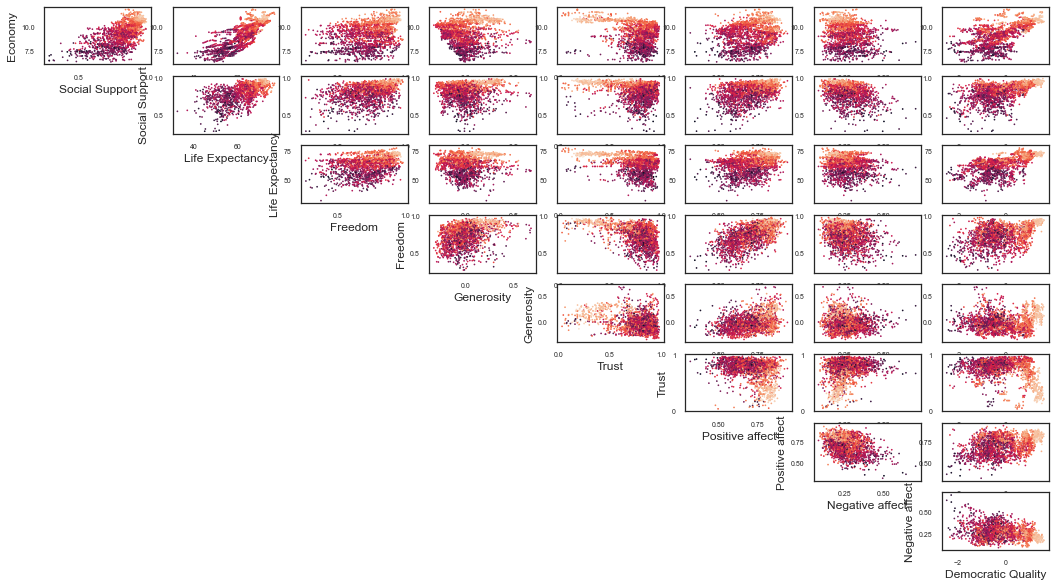

In [21]:
gs = gridspec.GridSpec(8, 8)
plt.figure(figsize=(18,10))
for ny in range(8):
    for nx in range(ny+1, 9):
        plt.subplot(gs[ny, nx-1])
        plt.scatter(X[:, nx], X[:, ny], c=y, s=.5)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7);
        if ny == nx-1:
            plt.xlabel(featurevector[nx])
            plt.ylabel(featurevector[ny])
plt.show()

Moving on to the PCA itself, we calculated and plotted the proporition of variance corresponding to 10 subsequent principal components, also in the form of cumulated variance per PC. We can see that there is no clear threshold above which the contribution of PCs drops drastically. That means there is no clear indication how many PCs are of a big importance and where we can cut off the redundant 'tail'.

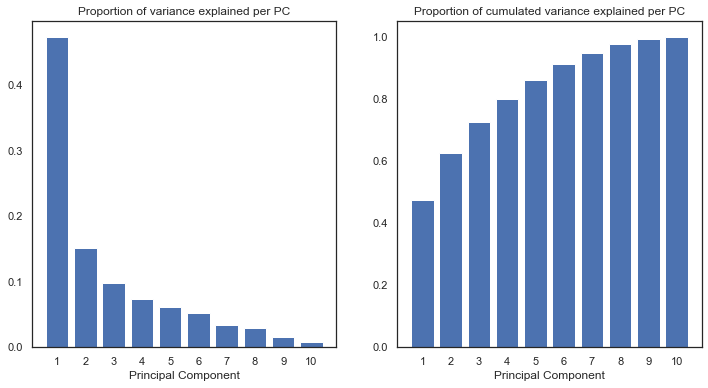

In [22]:
pca = PCA()
df_pca = pca.fit_transform(df_std[featurevector])

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.title('Proportion of variance explained per PC')
plt.xlabel('Principal Component')
plt.xticks(range(1, 11));

plt.subplot(1, 2, 2)
plt.bar(range(1, 11), pca.explained_variance_ratio_.cumsum())
plt.title('Proportion of cumulated variance explained per PC')
plt.xlabel('Principal Component')
plt.xticks(range(1, 11))
plt.show()

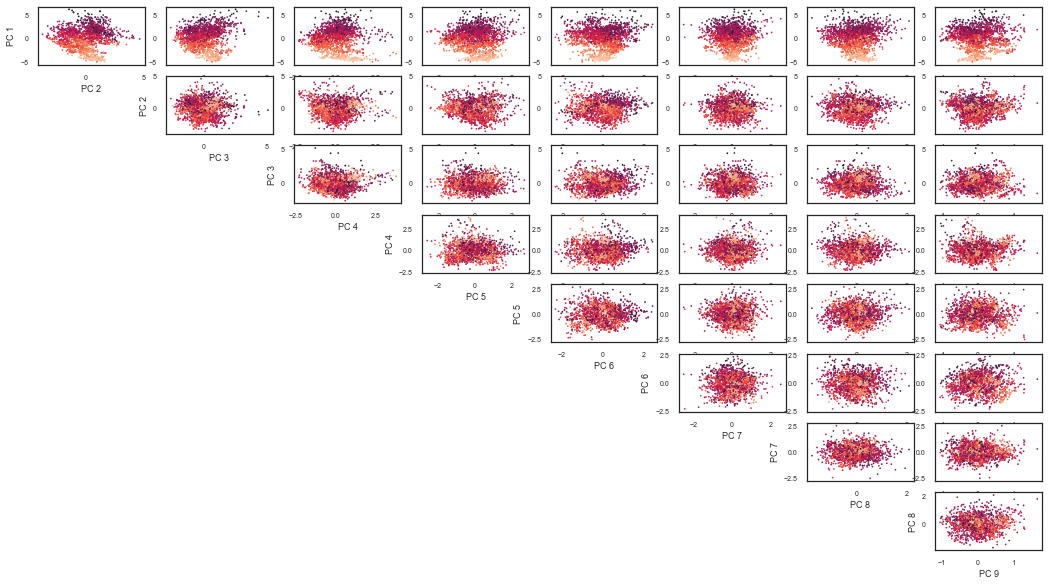

In [23]:
plt.figure(figsize=(18,10))
for ny in range(8):
    for nx in range(ny+1, 9):
        plt.subplot(gs[ny, nx-1])
        plt.scatter(df_pca[:, nx], df_pca[:, ny], c=y, s=0.5)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7);
        if ny == nx-1:
            plt.xlabel('PC {}'.format(nx+1), fontsize=9)
            plt.ylabel('PC {}'.format(ny+1), fontsize=9)
plt.show()

## Feature Scaling

### Using Pearson Correlation

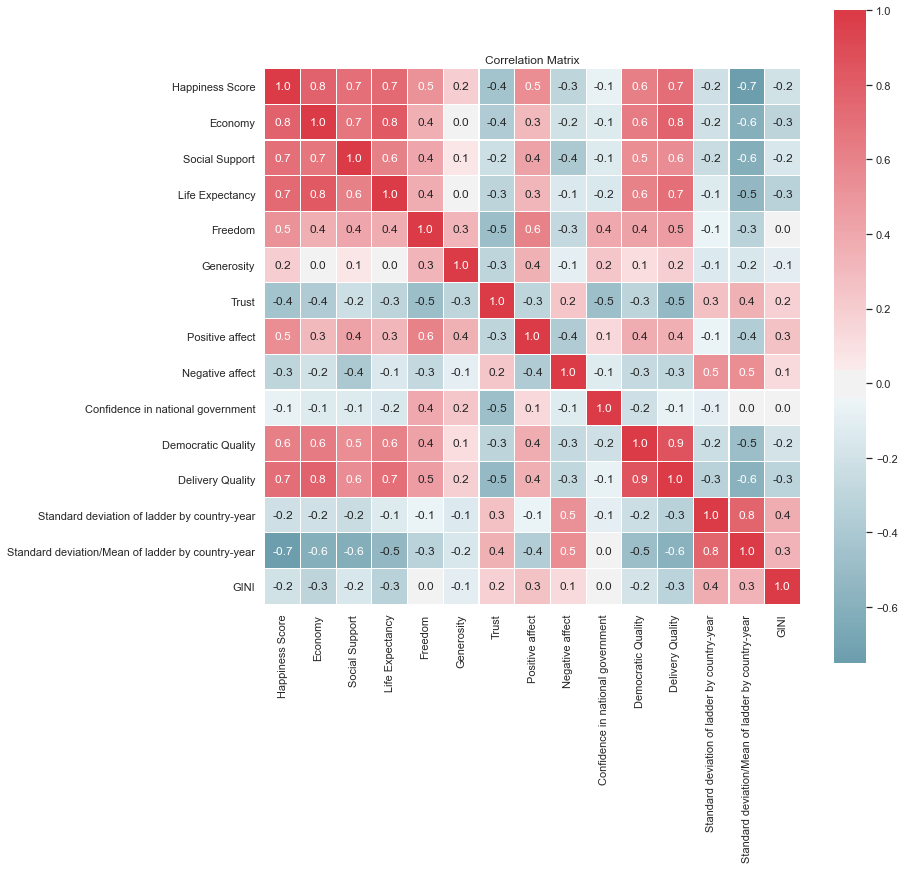

In [24]:
#Using Pearson Correlation
df_correl = df_std.drop(columns=['Year'])
f,ax = plt.subplots(figsize = (12, 12))
heat=sns.heatmap(df_correl.corr(), annot = True, linewidths = 0.1, fmt = '.1f', 
                 ax = ax, square = True,center=0,  cmap=sns.diverging_palette(220, 10, as_cmap=True))
heat.set(title='Correlation Matrix')
plt.show()

The matrix depicts correlation between each of the features using Pearson correlation method

In [25]:
#Correlation with output variable
cor = df_std.corr()
cor_target = abs(cor["Happiness Score"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

Happiness Score                                      1.000000
Economy                                              0.776599
Social Support                                       0.704699
Life Expectancy                                      0.740546
Freedom                                              0.517399
Positive affect                                      0.538000
Democratic Quality                                   0.623834
Delivery Quality                                     0.708404
Standard deviation/Mean of ladder by country-year    0.749778
Name: Happiness Score, dtype: float64

# Unsupervised Learning: Cluster Analysis

Another unsupervised technique which can bring insights into the nature and patterns existing in the data is Clustering method. By including an arbitrary set of X variables and plotting them in the multidimensional space we can discover similarities between groups of datapoints and thus draw conclusions.

We chose to use a centroid-based clustering method called k-means clustering. This method requires specifying the number of clusters (k). The algorithm then segregates the data into these k clusters under the assumption that each observation falls into the cluster with the nearest mean value. In the next step the algorithm re-stimates cluster centers to better fit to the assigned datapoint groups. Last two steps are repeated iteratively, until the convergence criterion is met.

We ran the clustering code for the number of clusters ranging from 2 to 10, plotted the results in the Happiness vs. Economy space and we observed that the best result (best separation of color-coded datapoints) could be observed for three clusters.

In [26]:
n_clusters = 3
KM = KMeans(n_clusters,  
            init='random', 
            n_init=20,     
            max_iter=300,
            tol=1e-04,  
            random_state=0)

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

groupsKM = KM.fit_predict(X_std)

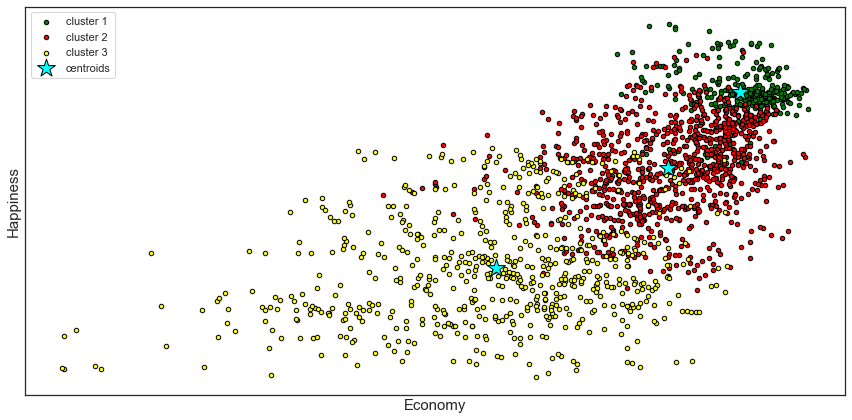

In [27]:
plt_col = ['green', 'red',  'yellow', 'blue','purple', 'pink', 'black', 'magenta', 'orange', 'brown']
plt.figure(figsize=(12,6))
for k in range(n_clusters):
    plt.scatter(X_std[groupsKM == k, 1],
                X_std[groupsKM == k, 0],
                s=20, c=plt_col[k],
                marker='o', edgecolor='black',
                label='cluster {}'.format(k+1))

plt.scatter(KM.cluster_centers_[:, 1],
            KM.cluster_centers_[:, 0],
            s=350, marker='*',
            c='cyan', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.xlabel("Economy", fontsize=15)
plt.ylabel("Happiness", fontsize=15)
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
plt.tight_layout()
plt.show()

Trying to interpret the meaning of three clusters we plotted a stacked bar chart to see whether any conclusions about geographical location of the datapoints falling into each cluster can be drawn.

1848


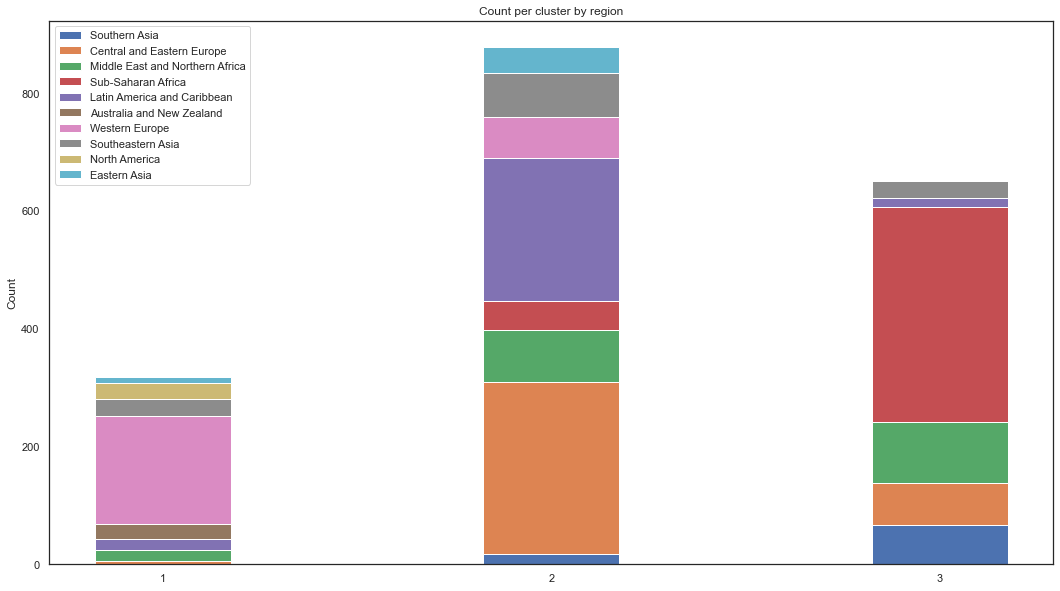

In [28]:
cum_arr = []
for i in df.Region.unique():
    part_arr = []
    for j in range(n_clusters):
        part_arr.append(df[groupsKM == j].loc[df['Region'] == i].shape[0])
    cum_arr.append(part_arr)
print(sum(sum(x) for x in cum_arr))

reg0 = np.array(cum_arr[0])
reg1 = np.array(cum_arr[1])
reg2 = np.array(cum_arr[2])
reg3 = np.array(cum_arr[3])
reg4 = np.array(cum_arr[4])
reg5 = np.array(cum_arr[5])
reg6 = np.array(cum_arr[6])
reg7 = np.array(cum_arr[7])
reg8 = np.array(cum_arr[8])
reg9 = np.array(cum_arr[9])

labels = [str(i) for i in range(1,n_clusters+1)]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(18,10))

ax.bar(labels, reg0, width, label='Southern Asia')
ax.bar(labels, reg1, width, label='Central and Eastern Europe', bottom=reg0)
ax.bar(labels, reg2, width, label='Middle East and Northern Africa', bottom=reg0+reg1)
ax.bar(labels, reg3, width, label='Sub-Saharan Africa', bottom=reg0+reg1+reg2)
ax.bar(labels, reg4, width, label='Latin America and Caribbean', bottom=reg0+reg1+reg2+reg3)
ax.bar(labels, reg5, width, label='Australia and New Zealand', bottom=reg0+reg1+reg2+reg3+reg4)
ax.bar(labels, reg6, width, label='Western Europe', bottom=reg0+reg1+reg2+reg3+reg4+reg5)
ax.bar(labels, reg7, width, label='Southeastern Asia', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6)
ax.bar(labels, reg8, width, label='North America', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6+reg7)
ax.bar(labels, reg9, width, label='Eastern Asia', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6+reg7+reg8)


ax.set_ylabel('Count')
ax.set_title('Count per cluster by region')
ax.legend()

plt.show()

At first it is hard to find a pattern, as many of colors correponding to world regions are spread across more than one cluster. However, after a closer look we have made a couple of observations:

- most of Western Europe, North America and Australia & New Zealand fall into one cluster
- Latin America & Carribean and Sub-Saharan Africa are very uniform - almost all datapoints were assigned to one cluster
- Southeastern Asia is spread across all three clusters, which can reflect inequalities amongst countries in this region of the world.

# Supervised Learning: Regression Analysis

At this point, we have already normalized and scaled our dataset and have filtered features which are highly correlated with our outcome variable. Now the goal is to estimate relationship between our feature set and the outcomes. Given that we have a continuous outcome variable (Happiness Score), we have employed different regression analysis types to establish the relationship between our features and outcomes which includes

Linear Regression
Support Vector Regression (SVR)
LASSO Regression
Elastic Net Regression
Decision Trees
Random Forest Regression
Principal Component Regression (PCR)
Performance parameters from each of these are compared at the end to find the the best fitting model for our dataset.

Before we start, it's important to check if our dataset fulfils the statistical assumptions for regression analysis. We have already verified multicollinearity in the previous sections and found no discrepancies as the Pearson Correlation heatmap of filtered features shows independent variables to be totally non-correlated with each other, hence fulfilling the requirement. Next step is to find if the relationship between our dependent and independent variables is linear, for which we have to perform the Linearity Test. The dataset is split into 2 groups for training and testing. This split ensures we have separate data for testing as well as lowers the occurence of overtraining.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_std=df_std[featurevector].values
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y, test_size=0.3, random_state=1)

## Linearity Test

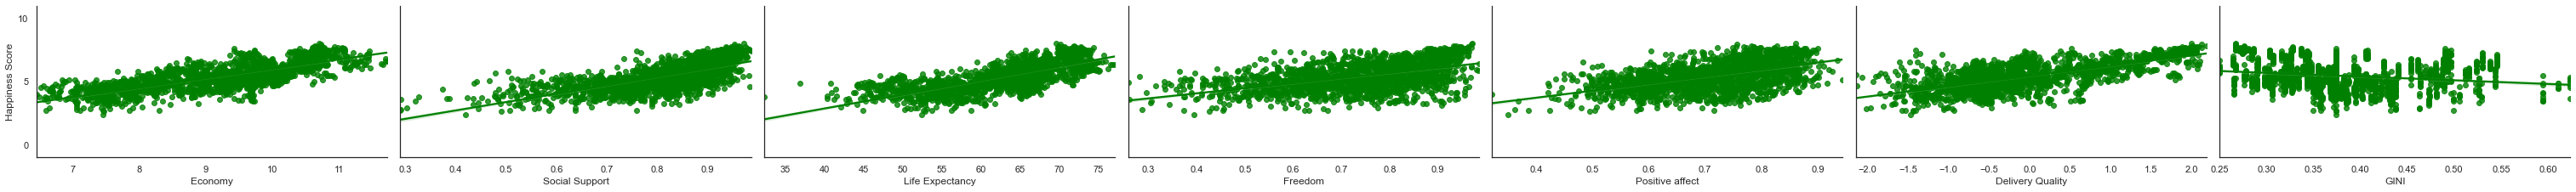

In [30]:
g = sns.PairGrid(df, y_vars=["Happiness Score"], x_vars=['Economy', 'Social Support', 'Life Expectancy',
       'Freedom', 'Positive affect', 'Delivery Quality', 
       'GINI'], height=3, aspect =2)
g.map(sns.regplot, color="green")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])
plt.show()

## Linear Regression 

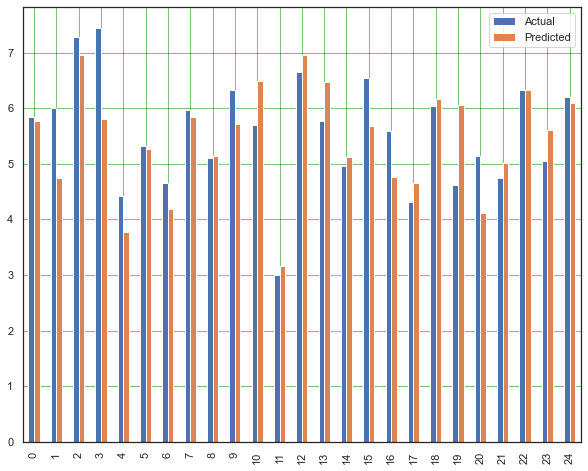

In [31]:
logR = LinearRegression()
logR.fit(X_train_std,y_train_std)
y_pred_logR = logR.predict(X_test_std)

df_logR = pd.DataFrame({'Actual': y_test_std, 'Predicted': y_pred_logR})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [32]:
analysis_score(logR,X_test_std,y_test_std,y_pred_logR)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 44
Test data accuracy: 0.72
Mean squared error: 0.34
Coefficient of determination: 0.72


## Support Vector Regression

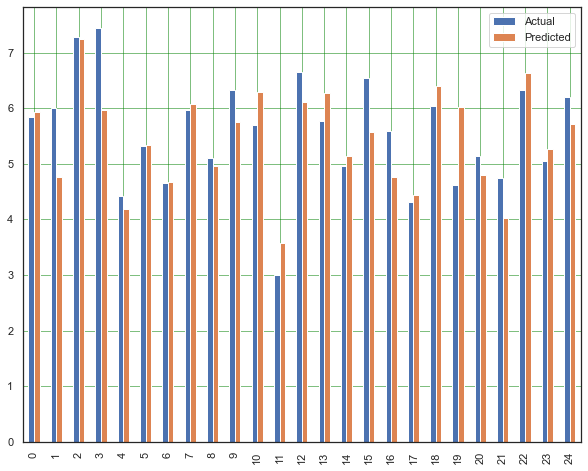

In [33]:
svr = SVR()
svr.fit(X_train_std, y_train_std)
y_pred_svr = svr.predict(X_test_std)

df_logR = pd.DataFrame({'Actual': y_test_std, 'Predicted': y_pred_svr})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [34]:
analysis_score(svr,X_test_std,y_test_std,y_pred_svr)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 20
Test data accuracy: 0.83
Mean squared error: 0.21
Coefficient of determination: 0.83


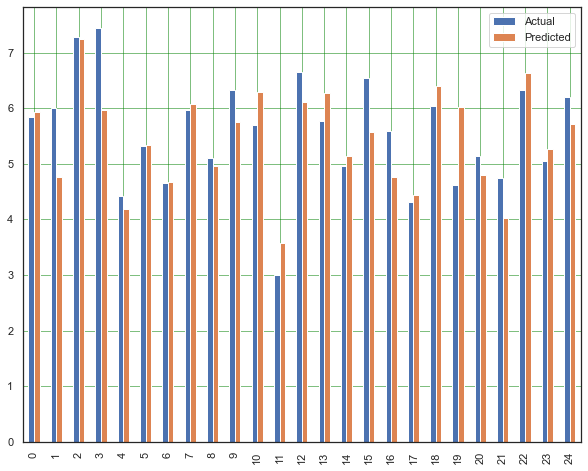

In [35]:
df_svr = pd.DataFrame({'Actual': y_test_std, 'Predicted': y_pred_svr})
df2 = df_svr.head(25)

df2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Least Absolute Shrinkage and Selection Operator (LASSO)

In [36]:
lasso = Lasso(alpha=0.1, max_iter = 10000)  
lasso.fit(X_train_std, y_train_std)
y_pred_train_Lasso  = lasso.predict(X_train_std)
y_pred_test_Lasso  = lasso.predict(X_test_std)
print(lasso.coef_)

[ 0.31391083  0.20032637  0.2214359   0.03293394  0.         -0.06505005
  0.20685638 -0.          0.          0.06758897]


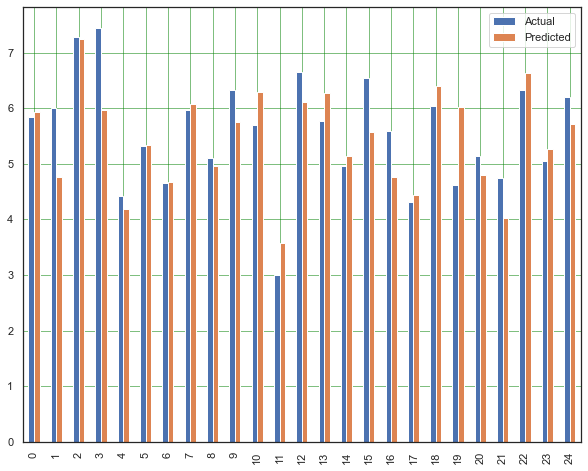

In [37]:
df_logR = pd.DataFrame({'Actual': y_test_std, 'Predicted': y_pred_svr})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [38]:
analysis_score(lasso,X_test_std,y_test_std,y_pred_test_Lasso)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 63
Test data accuracy: 0.73
Mean squared error: 0.34
Coefficient of determination: 0.73


## Elastic Net

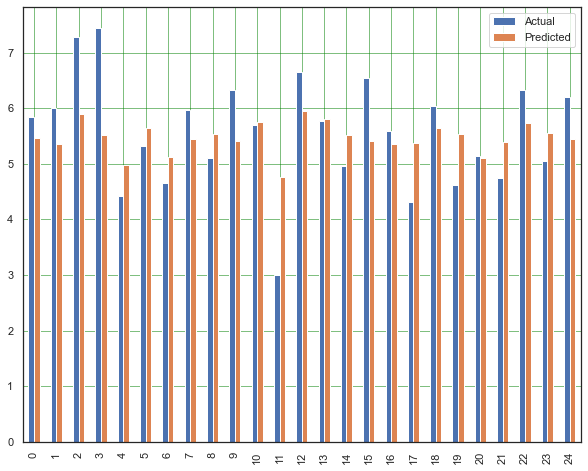

In [39]:
elnet = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter = 100)
elnet.fit(X_train_std, y_train_std)
y_pred_train_Elnet = elnet.predict(X_train_std)
y_pred_test_Elnet = elnet.predict(X_test_std)

df_logR = pd.DataFrame({'Actual': y_test_std, 'Predicted': y_pred_test_Elnet})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [40]:
analysis_score(elnet,X_test_std,y_test_std,y_pred_test_Elnet)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 415
Test data accuracy: 0.40
Mean squared error: 0.74
Coefficient of determination: 0.40


## Decision Tree

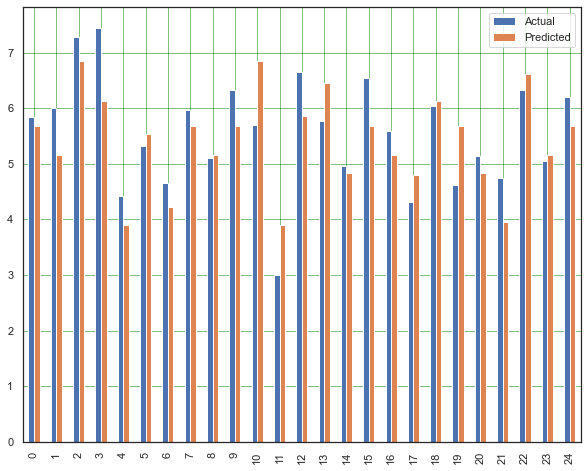

In [41]:
DTree = DecisionTreeRegressor(max_depth=5)
DTree.fit(X_train, y_train)
y_pred_train_DTree = DTree.predict(X_train)
y_pred_test_DTree = DTree.predict(X_test)

df_logR = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_DTree})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [42]:
analysis_score(DTree,X_test,y_test,y_pred_test_DTree)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 26
Test data accuracy: 0.79
Mean squared error: 0.26
Coefficient of determination: 0.79


## Random Forest

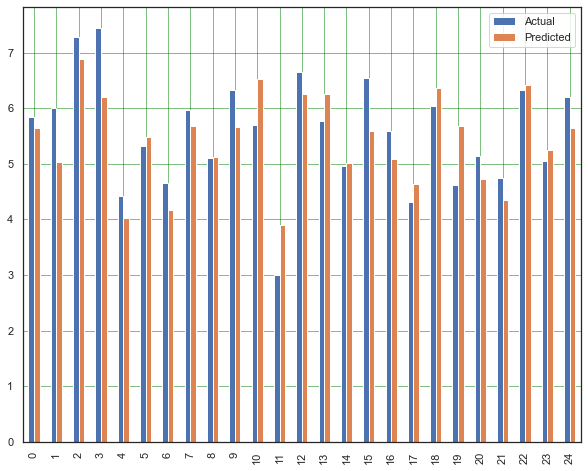

In [43]:
RForest = RandomForestRegressor(max_depth=5)
RForest.fit(X_train, y_train)
y_pred_train_RForest = RForest.predict(X_train)
y_pred_test_RForest = RForest.predict(X_test)

df_logR = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_RForest})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [44]:
analysis_score(RForest,X_test,y_test,y_pred_test_RForest)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 18
Test data accuracy: 0.82
Mean squared error: 0.22
Coefficient of determination: 0.82


## Principle Component Regression

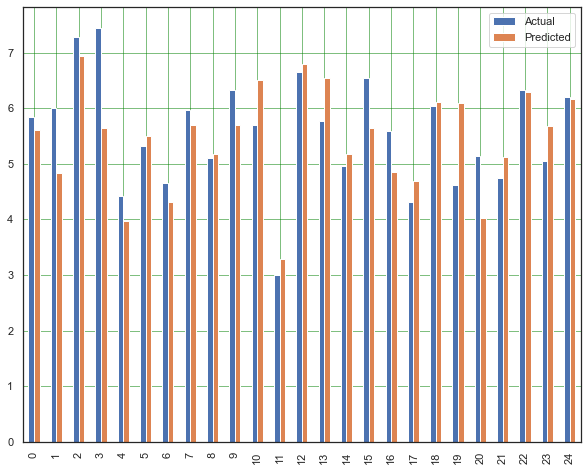

In [45]:
pca = PCA(n_components=6)  
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

linRPCA = LinearRegression()
linRPCA = linRPCA.fit(X_train_pca, y_train_std)
y_pred_pca = linRPCA.predict(X_test_pca)

df_logR = pd.DataFrame({'Actual': y_test_std, 'Predicted': y_pred_pca})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [46]:
analysis_score(linRPCA,X_test_pca,y_test_std,y_pred_pca)

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 43
Test data accuracy: 0.72
Mean squared error: 0.34
Coefficient of determination: 0.72


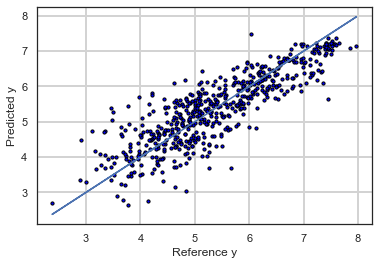

In [47]:
plt.scatter(y_test, y_pred_pca, c='blue', edgecolor='black', s=10)
plt.xlabel('Reference y')
plt.ylabel('Predicted y')
plt.plot(y_test_std, y_test_std)
plt.grid(color='LightGrey', linestyle='-', linewidth=2)
plt.show()

# Comparison Between Different algorithms

In [48]:
comparison = pd.DataFrame(data=performance_metrics[1:][:],columns=performance_metrics[0],index=['Linear Regression','SVR','LASSO','Elastic Net','Decision Tree','Random Forest','PCR'])


trace2 = go.Bar(
                x = comparison.index,
                y = comparison.Accuracy,
                name = performance_metrics[0][1],
                marker = dict(color = 'rgba(255, 0, 0, 1)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace3 = go.Bar(
                x = comparison.index,
                y = comparison[performance_metrics[0][2]],
                name = performance_metrics[0][2],
                marker = dict(color = 'rgba(0, 255, 0, 1)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace4 = go.Bar(
                x = comparison.index,
                y = comparison[performance_metrics[0][3]],
                name = performance_metrics[0][3],
                marker = dict(color = 'rgba(0, 0, 255, 1)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )

data = [trace2,trace3,trace4]
layout = go.Layout(barmode = 'group', title = 'Comparison of Performance for different prediction models')
fig = go.Figure(data = data, layout = layout)
iplot(fig)
print(time()-start)

29.046351194381714
